# Expected Coverage Probability

Trying to understand how to calcualte ECP for simulation based inference so that I can try and validate my posteriors. There is a good description of how to calcualte ECP in this paper by Pablo Lemos et al. https://arxiv.org/pdf/2302.03026.pdf.

If we have a set of $N_{sim}$ simulations $\{\theta_i, x_i\}$ then the algorithm runs as follows

---
- for simulation $x_i$

    - generate $n$ samples $\{\theta_{ij}\}\sim P(\theta|x_j)$

    - define $f_i = \frac{1}{n} \sum^n_j \boldsymbol{1}[\hat{p}(\theta_{ij}|x_j) < \hat{p}(\theta_i|x_j)]$

- define $\alpha$ to be a list of values between 0 and 1

- for each $\alpha$

    - define ECP $= \frac{1}{N_{sim}} \sum^{N_{sim}}_i \boldsymbol{1}[f_i < 1- \alpha]$

- plot ECP versus $1-\alpha$

---

where $\hat{p}$ is the prediction of the posterior and $\boldsymbol{1}[]$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function).

## Coding this up

Start with imports. Define a simualtor, prior to samples from, posterior probability  and a function to generate samples from the posterior (I guess this would be nested sampling/MCMC).

Here my data is $x = \theta^2$ plus some gaussian distributed noise.

Hmm my posterior is really a likelihood but you get the idea.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

def simulator(theta):
    return theta**2 + np.random.normal(0, 0.5, 1)

def prior(N):
    return np.random.uniform(1, 2, N)

def posterior(theta, data):
    return norm.pdf(theta**2, loc=data, scale=0.5)

def generate_samples(n, data):
    return np.sqrt(norm.rvs(loc=data, scale=0.5, size=n))

Next generate samples and corresponding simulations.

In [2]:
N = 100
samples = prior(N)
data = np.array([simulator(samples[i]) for i in range(N)])

Now calculate $f$ for each of the simulations $x_i(\theta_i)$.

In [3]:
f = []
for j in tqdm(range(len(data))):
    test_samples = generate_samples(2000, data[j]) # samples from P(theta|x_i) i.e. theta_ij
    # comparing P(theta_ij|x_i) and P(theta_i|x_i)
    ff = np.mean([1 if posterior(test_samples[t], data[j]) < 
                  posterior(samples[j], data[j]) else 0 for t in range(len(test_samples))])
    f.append(ff)

  4%|▍         | 4/100 [00:00<00:07, 12.95it/s]/var/folders/pk/s11gmpgj1_d0jt1ykgfx7rt80000gn/T/ipykernel_45663/3467198495.py:16: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(norm.rvs(loc=data, scale=0.5, size=n))
100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


Now define $\alpha$ and calculate ECP.

In [4]:
ecp = []
alpha=np.linspace(0, 1, 100)
for j in range(len(alpha)):
    e = np.mean([1 if f[i] < (1 - alpha[j]) else 0 for i in range(len(data))])
    ecp.append(e)
ecp = np.array(ecp)

Now plot.

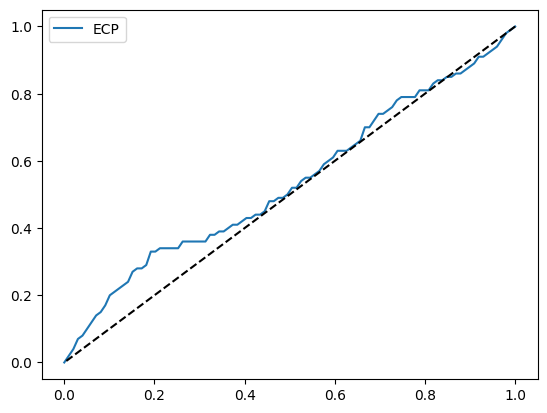

In [5]:
plt.plot(1- alpha, ecp, label='ECP')
plt.plot(1- alpha, 1 - alpha, ls='--', c='k')
plt.legend()
plt.show()